In [330]:
"""
Eng. khaled hoshme
Suggesting a convolutional neural network to identify pizza and distinguish it from other diets
"""

'\nEng. khaled hoshme\nSuggesting a convolutional neural network to identify pizza and distinguish it from other diets\n'

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaledhoshme
Your Kaggle Key: ··········


100%|██████████| 101M/101M [00:00<00:00, 195MB/s] 


In [335]:
import tensorflow as tf
import cv2
import os
import numpy as np
import pandas as pd
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import matplotlib.pylab as plt
import keras

In [288]:
img_width = 224
img_height = 224
batch_size = 32
color = 3
validation_split = 0.1
epochs = 200
learning_rate = 0.001
loss = "binary_crossentropy"

In [289]:
datasetFolder = os.path.join("pizza-not-pizza", "pizza_not_pizza")

In [290]:
dataset = pathlib.Path(datasetFolder)

In [291]:
list_images = list(dataset.glob("*/*.*"))

In [292]:
len(list_images)

1966

In [293]:
def show_single_image(img):
  img = cv2.imread(os.path.join(img))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()

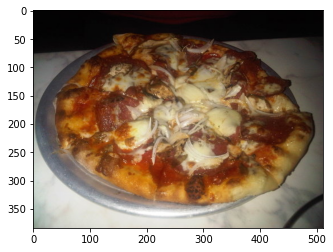

In [294]:
pizza_img = list(dataset.glob("pizza/*.*"))[0]
show_single_image(pizza_img)

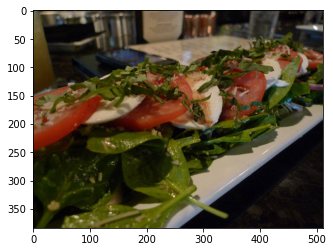

In [295]:
pizza_img = list(dataset.glob("not_pizza/*.*"))[0]
show_single_image(pizza_img)

Dataset images include a number of features that we do not need, which can affect the performance of the neural network during the training phase.
These features include (a spoon or fork and other objects found near the images of pizza and non-pizza), so in order to try to make the convolutional neural network able to focus on properties that represent only the pizza and change the pizza, without caring for the other objects, I proposed to create a circular mask, and implement it On all dataset photos, with the aim of focusing on the meal only without caring about the rest of the things

In [296]:
def masking_image(src):
  Img = np.zeros((224, 224, 3), dtype=np.uint8)
  center_coordinates = (int(224/2), int(224/2))
  radius = 100
  color = (255, 255, 255)
  image = cv2.circle(Img, center_coordinates, radius, color, -1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  ret, mask = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY_INV)
  mask = cv2.bitwise_not(mask)
  image_after_masking = cv2.bitwise_and(src,src,mask = mask)
  return image_after_masking

In [309]:
pizza_generator = ImageDataGenerator( rescale=1/255, validation_split=validation_split,vertical_flip=True ,horizontal_flip=True,
                              rotation_range = 5, shear_range = 0.02,zoom_range = 0.02, preprocessing_function = masking_image)
train_generator = pizza_generator.flow_from_directory(
    datasetFolder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training')
validation_generator = pizza_generator.flow_from_directory(
    datasetFolder, 
    target_size=(img_height, img_width),
    batch_size= batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation') 


Found 1770 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


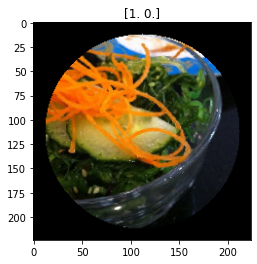

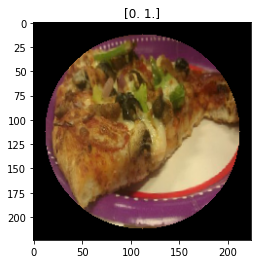

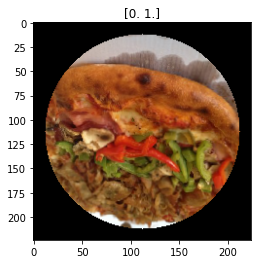

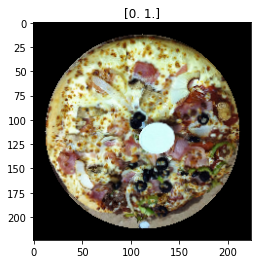

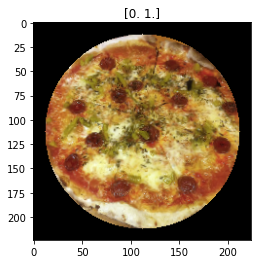

In [334]:
single_batch = train_generator.next() 
images = single_batch[0] 
labels = single_batch[1] 
for i in range(5):
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.show()

In [299]:
classes_name = list(train_generator.class_indices)
classes_name

['not_pizza', 'pizza']

In [300]:
def vgg19_teranfer_learning(classes_name):
  mo = keras.applications.vgg19
  vg19MODEL = mo.VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, color))
  M = keras.layers.Dropout(0.2)(vg19MODEL.output)
  M = keras.layers.Flatten()(M)
  M = keras.layers.Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  M = keras.layers.Dropout(0.2)(M)
  M = keras.layers.Dense(128, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  M = keras.layers.Dropout(0.2)(M)
  M = keras.layers.Dense(64, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  M = keras.layers.Dropout(0.2)(M)
  M = keras.layers.Dense(32, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  M = keras.layers.Dropout(0.2)(M)
  M = keras.layers.Dense(16, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  M = keras.layers.Dropout(0.2)(M)
  predictions = keras.layers.Dense(len(classes_name), activation='softmax', bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(M)
  mo = keras.models.Model(inputs=vg19MODEL.input, outputs=predictions)
  for layer in mo.layers[:20]:
      layer.trainable = False
  for layer in mo.layers[20:]:
      layer.trainable = True
  return mo

In [301]:
model = vgg19_teranfer_learning(classes_name)

In [302]:
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [303]:
model.layers[20:]

In [304]:
model.compile(loss = loss, optimizer= tf.keras.optimizers.Adam(learning_rate= learning_rate),
              metrics = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
])

In [306]:
hist = model.fit(train_generator,  batch_size = batch_size, epochs = epochs,
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True))

Epoch 1/200
56/56 [==============================] - 26s 466ms/step - loss: 1.0920 - tp: 1058.0000 - fp: 712.0000 - tn: 1058.0000 - fn: 712.0000 - accuracy: 0.5977 - precision: 0.5977 - recall: 0.5977 - auc: 0.6703
Epoch 2/200
56/56 [==============================] - 26s 466ms/step - loss: 0.8606 - tp: 1281.0000 - fp: 489.0000 - tn: 1281.0000 - fn: 489.0000 - accuracy: 0.7237 - precision: 0.7237 - recall: 0.7237 - auc: 0.7775
Epoch 3/200
56/56 [==============================] - 26s 469ms/step - loss: 0.7307 - tp: 1435.0000 - fp: 335.0000 - tn: 1435.0000 - fn: 335.0000 - accuracy: 0.8107 - precision: 0.8107 - recall: 0.8107 - auc: 0.8572
Epoch 4/200
56/56 [==============================] - 26s 464ms/step - loss: 0.6124 - tp: 1504.0000 - fp: 266.0000 - tn: 1504.0000 - fn: 266.0000 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.8932
Epoch 5/200
56/56 [==============================] - 26s 464ms/step - loss: 0.5131 - tp: 1532.0000 - fp: 238.0000 - tn: 1532.0000 - fn: 238.

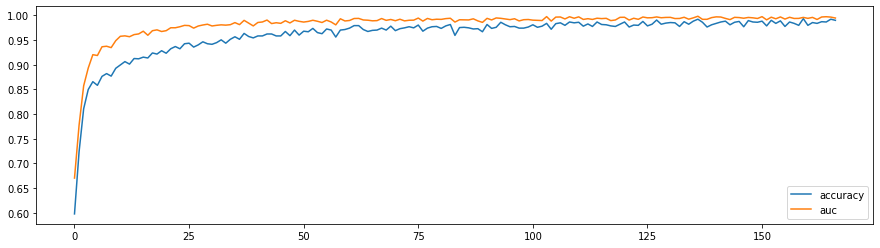

In [324]:
figure = plt.figure(figsize=(15, 4))
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['auc'], label = "auc")
plt.legend()

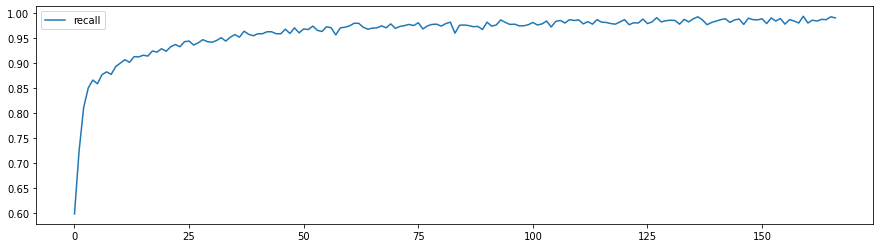

In [327]:
figure = plt.figure(figsize=(15, 4))
plt.plot(hist.history['recall'], label = "recall")
plt.legend()

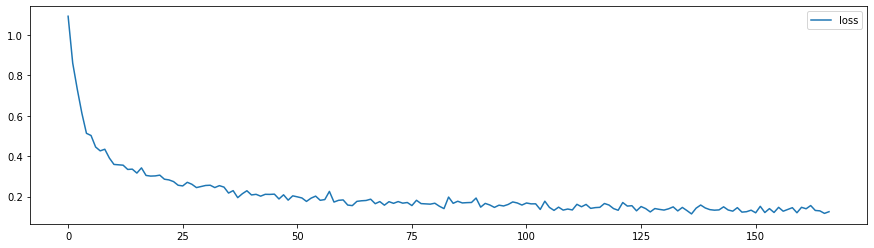

In [332]:
figure = plt.figure(figsize=(15, 4))
plt.plot(hist.history['loss'], label = "loss")
plt.legend()

In [310]:
validation_generator.reset()

In [311]:
model.evaluate(validation_generator, batch_size = batch_size, steps= validation_generator.n // validation_generator.batch_size)

6/6 [==============================] - 4s 478ms/step - loss: 0.5149 - tp: 169.0000 - fp: 23.0000 - tn: 169.0000 - fn: 23.0000 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.8943


[0.5149038434028625,
 169.0,
 23.0,
 169.0,
 23.0,
 0.8802083134651184,
 0.8802083134651184,
 0.8802083134651184,
 0.894260048866272]

In [313]:
Y_pred = model.predict(validation_generator,  workers=1)
y_pred = np.argmax(Y_pred ,  axis = 1)

In [315]:
res = tf.math.confusion_matrix(y_pred,validation_generator.classes).numpy()
confusion_matrix = pd.DataFrame(res,
                     index = classes_name, 
                     columns = classes_name)

In [316]:
confusion_matrix

,not_pizza,pizza
not_pizza,89,13
pizza,9,85


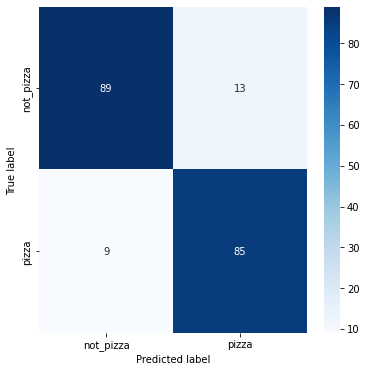

In [320]:
import seaborn as sns
figure = plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()